# Model Ref 3b - with modifications

In [ ]:
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

In [1]:
import keras
import pandas as pd
import tensorflow as tf

import numpy as np
# from keras.models import Sequential, Model
# from keras.layers import Dense, Dropout, Activation, Flatten, Convolution2D, MaxPooling2D, GlobalAveragePooling2D
from keras.utils import np_utils

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Convolution2D, MaxPooling2D, GlobalAveragePooling2D, Input,AveragePooling2D, BatchNormalization, LeakyReLU

# from keras.applications import MobileNet
# from keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2, InceptionV3
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import Adadelta
from keras.regularizers import l2

from matplotlib import pyplot as plt
import os
from sklearn.model_selection import train_test_split

import seaborn as sns
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.model_selection import KFold

from collections import defaultdict
from PIL import Image

Using TensorFlow backend.


# Data Loading and Prep

In [2]:
def getSpeciesCode(x):
    part = x.split('_')
    if part[0] == 'ASETRI':
        return 0
    elif part[0] == 'EPTBOT':
        return 1
    elif part[0] == 'MYOEMA':
        return 2
    elif part[0] == 'PIPKUH':
        return 3
    elif part[0] == 'RHIMUS':
        return 4
    elif part[0] == 'RHYNAS':
        return 5
    elif part[0] == 'ROUAEG':
        return 6
    elif part[0] == 'TAPPER':
        return 7
    else:
        return 'Unknown'
    
def getSpecies(x):
    if x == 0:
        return 'ASETRI'
    elif x == 1:
        return 'EPTBOT'
    elif x == 2:
        return 'MYOEMA'
    elif x == 3:
        return 'PIPKUH'
    elif x == 4:
        return 'RHIMUS'
    elif x == 5:
        return 'RHYNAS'
    elif x == 6:
        return 'ROUAEG'
    elif x == 7:
        return 'TAPPER'
    else:
        return 'Unknown'

In [3]:
image_folder_path = 'data/SpectogramInitial'
file_paths = [f for f in os.listdir(image_folder_path)]
species = []
for file_name in file_paths:
    sp = file_name.split('_')
    species.append(sp[0])

df = pd.DataFrame(species, columns=['Species'])
df['Species'].value_counts()

RHIMUS    1799
TAPPER     429
PIPKUH     303
RHYNAS     271
EPTBOT     131
ROUAEG     121
MYOEMA     114
ASETRI      25
Name: Species, dtype: int64

In [4]:
X_all = []
Y_all = []

image_folder_path = 'data/SpectogramInitial'
file_paths = [f for f in os.listdir(image_folder_path)]

for file_name in file_paths:
    spectrogram = Image.open(image_folder_path + '/' + file_name)
    spectrogram = spectrogram.convert('L')
    spectrogram = np.array(spectrogram)
    spectrogram = np.expand_dims(spectrogram, axis=2)
    X_all.append(spectrogram)
    Y_all.append(getSpeciesCode(file_name))
    

#plt.imshow(X_all[0])

In [5]:
X_all = np.array(X_all)
Y_all = np.array(Y_all)

print(X_all.shape)
print(Y_all.shape)

X_all = X_all.astype('float32')
X_all /= 255

Y_all = np_utils.to_categorical(Y_all, num_classes=8)

print(X_all[0])
print(Y_all)

(3193, 224, 341, 1)
(3193,)
[[[1.]
  [1.]
  [1.]
  ...
  [1.]
  [1.]
  [1.]]

 [[1.]
  [1.]
  [1.]
  ...
  [1.]
  [1.]
  [1.]]

 [[1.]
  [1.]
  [1.]
  ...
  [1.]
  [1.]
  [1.]]

 ...

 [[1.]
  [1.]
  [1.]
  ...
  [1.]
  [1.]
  [1.]]

 [[1.]
  [1.]
  [1.]
  ...
  [1.]
  [1.]
  [1.]]

 [[1.]
  [1.]
  [1.]
  ...
  [1.]
  [1.]
  [1.]]]
[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


In [6]:
# train /test= 80/20% split
# Data is stratified
X_train, X_test, Y_train, Y_test = train_test_split(X_all, Y_all, test_size=0.2, random_state = 123, stratify=Y_all)


# Model Building

In [7]:
def build_current_model():
    inp = Input(shape=(224, 341, 1))
    
    c1 = Convolution2D(filters=64,kernel_size=(7,7),strides=(2,2),padding='same')(inp)
    bt = BatchNormalization()(c1)
    bt = Activation('relu')(bt)
    mpool1 = MaxPooling2D(pool_size=(3,3),strides=2,padding='same')(bt)
    
    c2 = Convolution2D(filters=128,kernel_size=(7,7),strides=(2,2),padding='same')(mpool1)
    bt = BatchNormalization()(c2)
    bt = Activation('relu')(bt)
    mpool2 = AveragePooling2D(pool_size=(3,3),strides=(2,2),padding='same')(bt)
    
    c3 = Convolution2D(filters=256,kernel_size=(3,3),strides=(2,2),padding='same')(mpool2)
    bt = BatchNormalization()(c3)
    bt = Activation('relu')(bt)
    mpool3 = AveragePooling2D(pool_size=(3,3),strides=(2,2),padding='same')(bt)
    
    c4 = Convolution2D(filters=512,kernel_size=(3,3),strides=(2,2),padding='same')(mpool3)
    bt = BatchNormalization()(c4)
    bt = Activation('relu')(bt)
    mpool4 = AveragePooling2D(pool_size=(3,3),strides=(2,2),padding='same')(bt)
    
    f = Flatten()(mpool4)
    dp = Dropout(0.2)(f)
    x_dense = Dense(4096, activation='relu')(dp)
    
    dp2 = Dropout(0.2)(x_dense)
    x_dense2 = Dense(2048, activation='relu')(dp2)
    
    dp3 = Dropout(0.2)(x_dense2)
    x_dense3 = Dense(512, activation='relu')(dp3)
    
    x_out = Dense(8, name='output', activation='softmax', kernel_regularizer = l2(0.01))(x_dense3)
    model = Model(inputs=inp, outputs=x_out)
    model.compile(optimizer=Adadelta(lr = 0.002), 
                  loss='categorical_hinge', 
                  metrics = ['accuracy'])
    return model


In [8]:
model = build_current_model()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 341, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 112, 171, 64)      3200      
_________________________________________________________________
batch_normalization (BatchNo (None, 112, 171, 64)      256       
_________________________________________________________________
activation (Activation)      (None, 112, 171, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 56, 86, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 43, 128)       401536    
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 43, 128)       512   

In [9]:
from sklearn.utils.class_weight import compute_class_weight

# the original 1D tensor for y
y_flat = np.argmax(Y_train, axis=1)
# handling imbalanced data 
class_weight = compute_class_weight('balanced', np.unique(y_flat), y_flat)

print(y_flat.shape)
print(class_weight)

(2554,)
[15.9625      3.04047619  3.50824176  1.31921488  0.22185546  1.47119816
  3.29123711  0.93075802]


In [10]:
history = model.fit(X_train, Y_train, 
              epochs = 200, 
              validation_split=0.1, 
              verbose=1, 
              batch_size = 32,
              class_weight = class_weight)

history_info = history.history

Train on 2298 samples, validate on 256 samples
Epoch 1/200
2298/2298 [==============================] - 17s 7ms/sample - loss: 1.1784 - accuracy: 0.3412 - val_loss: 1.1617 - val_accuracy: 0.0352
Epoch 2/200
2298/2298 [==============================] - 11s 5ms/sample - loss: 1.1370 - accuracy: 0.5601 - val_loss: 1.1566 - val_accuracy: 0.5703
Epoch 3/200
2298/2298 [==============================] - 11s 5ms/sample - loss: 1.1012 - accuracy: 0.5627 - val_loss: 1.1376 - val_accuracy: 0.5703
Epoch 4/200
2298/2298 [==============================] - 11s 5ms/sample - loss: 1.0590 - accuracy: 0.5627 - val_loss: 1.1044 - val_accuracy: 0.5703
Epoch 5/200
2298/2298 [==============================] - 11s 5ms/sample - loss: 1.0209 - accuracy: 0.5627 - val_loss: 1.0671 - val_accuracy: 0.5703
Epoch 6/200
2298/2298 [==============================] - 11s 5ms/sample - loss: 0.9902 - accuracy: 0.5627 - val_loss: 1.0421 - val_accuracy: 0.5703
Epoch 7/200
2298/2298 [==============================] - 11s 5ms/

Epoch 56/200
2298/2298 [==============================] - 11s 5ms/sample - loss: 0.6572 - accuracy: 0.7167 - val_loss: 0.6270 - val_accuracy: 0.7383
Epoch 57/200
2298/2298 [==============================] - 11s 5ms/sample - loss: 0.6515 - accuracy: 0.7145 - val_loss: 0.5964 - val_accuracy: 0.7539
Epoch 58/200
2298/2298 [==============================] - 11s 5ms/sample - loss: 0.6474 - accuracy: 0.7215 - val_loss: 0.5950 - val_accuracy: 0.7422
Epoch 59/200
2298/2298 [==============================] - 11s 5ms/sample - loss: 0.6471 - accuracy: 0.7211 - val_loss: 0.6125 - val_accuracy: 0.7500
Epoch 60/200
2298/2298 [==============================] - 11s 5ms/sample - loss: 0.6431 - accuracy: 0.7193 - val_loss: 0.5875 - val_accuracy: 0.7461
Epoch 61/200
2298/2298 [==============================] - 11s 5ms/sample - loss: 0.6417 - accuracy: 0.7254 - val_loss: 0.6245 - val_accuracy: 0.7461
Epoch 62/200
2298/2298 [==============================] - 11s 5ms/sample - loss: 0.6372 - accuracy: 0.7232

2298/2298 [==============================] - 11s 5ms/sample - loss: 0.5245 - accuracy: 0.7950 - val_loss: 0.4912 - val_accuracy: 0.8164
Epoch 111/200
2298/2298 [==============================] - 11s 5ms/sample - loss: 0.5147 - accuracy: 0.8003 - val_loss: 0.4822 - val_accuracy: 0.8086
Epoch 112/200
2298/2298 [==============================] - 11s 5ms/sample - loss: 0.5133 - accuracy: 0.8007 - val_loss: 0.4755 - val_accuracy: 0.8086
Epoch 113/200
2298/2298 [==============================] - 11s 5ms/sample - loss: 0.5154 - accuracy: 0.7998 - val_loss: 0.4760 - val_accuracy: 0.8125
Epoch 114/200
2298/2298 [==============================] - 11s 5ms/sample - loss: 0.5135 - accuracy: 0.8042 - val_loss: 0.5014 - val_accuracy: 0.7930
Epoch 115/200
2298/2298 [==============================] - 11s 5ms/sample - loss: 0.5079 - accuracy: 0.8129 - val_loss: 0.4995 - val_accuracy: 0.7852
Epoch 116/200
2298/2298 [==============================] - 11s 5ms/sample - loss: 0.5054 - accuracy: 0.8116 - val_

Epoch 165/200
2298/2298 [==============================] - 11s 5ms/sample - loss: 0.3859 - accuracy: 0.8738 - val_loss: 0.4050 - val_accuracy: 0.8398
Epoch 166/200
2298/2298 [==============================] - 11s 5ms/sample - loss: 0.3873 - accuracy: 0.8721 - val_loss: 0.3888 - val_accuracy: 0.8633
Epoch 167/200
2298/2298 [==============================] - 11s 5ms/sample - loss: 0.3925 - accuracy: 0.8699 - val_loss: 0.3927 - val_accuracy: 0.8516
Epoch 168/200
2298/2298 [==============================] - 11s 5ms/sample - loss: 0.3869 - accuracy: 0.8703 - val_loss: 0.3726 - val_accuracy: 0.8750
Epoch 169/200
2298/2298 [==============================] - 11s 5ms/sample - loss: 0.3903 - accuracy: 0.8716 - val_loss: 0.3657 - val_accuracy: 0.8750
Epoch 170/200
2298/2298 [==============================] - 11s 5ms/sample - loss: 0.3784 - accuracy: 0.8782 - val_loss: 0.4128 - val_accuracy: 0.8672
Epoch 171/200
2298/2298 [==============================] - 11s 5ms/sample - loss: 0.3821 - accuracy:

# Evaluation

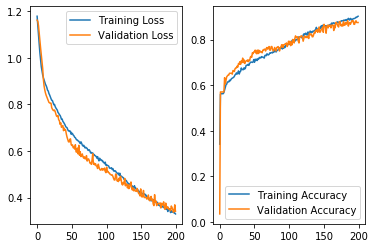

In [11]:
## Loss and accuracy history
_, axs = plt.subplots(ncols=2)
df_history_info = pd.DataFrame(history_info) 


sns.lineplot(data=df_history_info['loss'],ax=axs[0], label='Training Loss', legend='brief')
sns.lineplot(data=df_history_info['val_loss'],ax=axs[0], label='Validation Loss', legend='brief')

sns.lineplot(data=df_history_info['accuracy'],ax=axs[1], label='Training Accuracy', legend='brief')
sns.lineplot(data=df_history_info['val_accuracy'],ax=axs[1], label='Validation Accuracy', legend='brief')

In [12]:
def generate_actual_predicted(Y_pred, X_test, Y_test): 
    predicted = list()
    for i in range(len(Y_pred)):
        predicted.append(np.argmax(Y_pred[i]))
        
    actual = list()
    for i in range(len(Y_test)):
        actual.append(np.argmax(Y_test[i]))
        
    return actual, predicted

[[  0   0   2   1   0   0   0   2]
 [  0  15   0   2   0   8   0   1]
 [  0   0   4   8   1   2   1   7]
 [  0   0   0  54   2   4   1   0]
 [  0   0   0   0 356   0   0   4]
 [  0   0   0   6   1  45   2   0]
 [  0   0   0   2   1   1  18   2]
 [  0   0   0   2   8   0   1  75]]


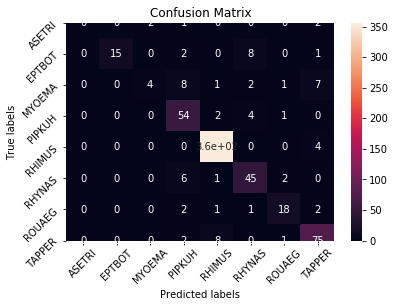

In [13]:
Y_pred = model.predict(X_test)
actual, predicted = generate_actual_predicted(Y_pred, X_test, Y_test)

##Confusion Matrix
from sklearn.metrics import confusion_matrix
actual_labeled = list()
predict_labeled = list()
for x,y in zip(actual,predicted):
    actual_labeled.append(getSpecies(x))
    predict_labeled.append(getSpecies(y))

labels = ['ASETRI','EPTBOT','MYOEMA','PIPKUH','RHIMUS','RHYNAS', 'ROUAEG', 'TAPPER']
cm=confusion_matrix(actual_labeled,predict_labeled,labels=labels)
print(cm)

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels, rotation = 45); ax.yaxis.set_ticklabels(labels,rotation=45);

In [14]:
## Test accuracy
from sklearn.metrics import accuracy_score
print('accuracy', accuracy_score(actual, predicted))


accuracy 0.8873239436619719


In [15]:
## Precision, Recall, F1, Support
from sklearn.metrics import classification_report
print(classification_report(actual_labeled, predict_labeled,labels=labels))

              precision    recall  f1-score   support

      ASETRI       0.00      0.00      0.00         5
      EPTBOT       1.00      0.58      0.73        26
      MYOEMA       0.67      0.17      0.28        23
      PIPKUH       0.72      0.89      0.79        61
      RHIMUS       0.96      0.99      0.98       360
      RHYNAS       0.75      0.83      0.79        54
      ROUAEG       0.78      0.75      0.77        24
      TAPPER       0.82      0.87      0.85        86

    accuracy                           0.89       639
   macro avg       0.71      0.64      0.65       639
weighted avg       0.88      0.89      0.88       639



C:\Users\Tasli\Anaconda3\envs\keras-gpu\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
